In [34]:
!date

Sun 27 May 2018 12:54:32 AWST


## Robuslty fitting a model to the data with outliers.


Data includes, 
* x: independent variable
* y: dependent variable
* sx, sy: associated uncertainties in x and y
* sxy: correlation between sx and sy.

The complexity of problem gradually increases as you progress through the code. Following are the major implementations so far, in order of increasing modelling complexity:

1. Exact linear fit: Linear Algebraic approach. Data used: (x,y,sy) with/out outliers
2. Exact quadratic fit: Linear Algebraic approach. (x,y,sy) with/out outliers
3. Bayesian fitting. (x, y, sy) without outliers
4. Bayesian fitting. (x, y, sy) with outliers and background modeling
        1. In case sy is known
        2. sy is known unknown, hence considering it a free parameter 
        3. sy is non-existence (case of perfect measurement), hence assuming sy=1 (correctness of this approach?)
5. To implement: 
        1. Bayesian fitting. (x, y, sy, sx) with outliers and errors in both x and y variables.
        2. Bayesian fitting. (x, y, sy, sx, sxy) with outliers, and correlated errors in x and y.

In [35]:
import numpy as np
import pymc3 as pm
import pandas as pd
import scipy.stats as st
#from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
from astroML.plotting import setup_text_plots
setup_text_plots(fontsize=8, usetex=False)

%matplotlib inline

def plotting_keys():
    plt.xlabel('x'); plt.ylabel('y')
    plt.xlim(0,300);plt.ylim(0,700)
    plt.minorticks_on()
    plt.legend()
    
def xest(x):
    m, est, p = np.percentile(x, [16, 50, 84])
    return est, est-m, p-est


### Data in hand

Reference and data source: Hogg et al. 2010 paper.
https://arxiv.org/pdf/1008.4686.pdf

In [36]:
    
table1 = np.array([[1, 201, 592, 61, 9, -0.84,],
                    [2, 244, 401, 25, 4, 0.31,],
                    [3, 47, 583, 38, 11, 0.64,],
                    [4, 287, 402, 15, 7, -0.27,],
                    [5, 203, 495, 21, 5, -0.33,],
                    [6, 58, 173, 15, 9, 0.67,],
                    [7, 210, 479, 27, 4, -0.02,],
                    [8, 202, 504, 14, 4, -0.05,],
                    [9, 198, 510, 30, 11, -0.84,],
                    [10, 158, 416, 16, 7, -0.69,],
                    [11, 165, 393, 14, 5, 0.30,],
                    [12, 201, 442, 25, 5, -0.46,],
                    [13, 157, 317, 52, 5, -0.03,],
                    [14, 131, 311, 16, 6, 0.50,],
                    [15, 166, 400, 34, 6, 0.73,],
                    [16, 160, 337, 31, 5, -0.52,],
                    [17, 186, 423, 42, 9, 0.90,],
                    [18, 125, 334, 26, 8, 0.40,],
                    [19, 218, 533, 16, 6, -0.78,],
                    [20, 146, 344, 22, 5, -0.56,]])

table1 = pd.DataFrame(table1, columns=['id', 'x', 'y', 'sy', 'sx', 'sxy'])
table1['id'] = table1['id'].astype(int)
table1.set_index('id', inplace=True)

Text(0,0.5,u'Y')

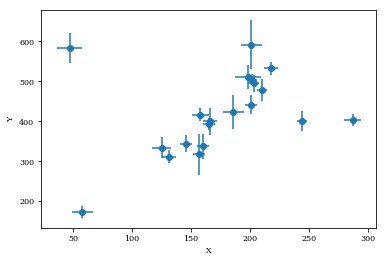

In [37]:
plt.errorbar(table1.x, table1.y, yerr=table1.sy, xerr=table1.sx, fmt='o')
plt.xlabel('X'); plt.ylabel('Y')

### Excercise 1: exact solution using Linear Algebra

#### Case I: Linear fit

In [38]:
def linear_algebraic_solution(df):
    Y = df.y.values
    X = df.x.values
    sY = df.sy.values
    A = np.vstack((np.ones(len(X)), X)).T
    C = np.diag(sY**2)
    invC = np.linalg.inv(C)

    # equation 5 bracket terms
    term_left = np.linalg.inv(np.dot(A.T, np.dot(invC, A)))
    term_right = np.dot(A.T,np.dot(invC, Y))

    b, m = np.dot(term_left, term_right)
    berr, merr = np.sqrt(np.diag(term_left))

    print "m=%1.2f \pm{%1.2f}, b=%2d \pm{%2d}"%(m, merr, b, berr)
    
    return [m, merr, b, berr], [X, Y, sY]

m=2.24 \pm{0.11}, b=34 \pm{18}


,case,data,m,merr,b,berr
0,Exact solution,"(x,y,sy) w/o outliers",2.239921,0.10778,34.047728,18.246167


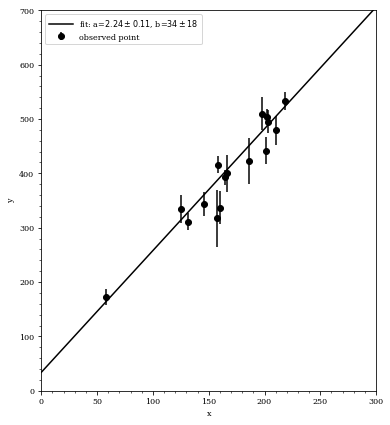

In [39]:
trimmed_table1 = table1.loc[5:20]

est, dat = linear_algebraic_solution(trimmed_table1)
m, merr, b, berr = est
X, Y, sY = dat

Xp = np.linspace(0, 300, 100)
fig1 = plt.figure(figsize=(6,7))
plt.plot(Xp, m*Xp+b, 'k', 
         label='fit: a=$%5.2f\pm{%5.2f}$, b=$%5d\pm{%5d}$'%(m, merr, 
                                                            b, berr) )
plt.errorbar(X, Y, yerr=sY, fmt='ko', label='observed point')
plotting_keys()

# Storing result in a dataframe
caseI_result = {'m':[m], 'merr':[merr], 'b': [b], 'berr':[berr], 'case':['Exact solution'], 
                'data':['(x,y,sy) w/o outliers']}

result_df = pd.DataFrame.from_dict(caseI_result)

#### Linear Fit:  Repeating case I with full data (outliers inclusive)

m=1.08 \pm{0.08}, b=213 \pm{14}


,case,data,m,merr,b,berr
0,Exact solution,"(x,y,sy) w/o outliers",2.239921,0.107780,34.047728,18.246167
1,Exact solution,"(x,y,sy) with outliers",1.076748,0.077407,213.273492,14.394033


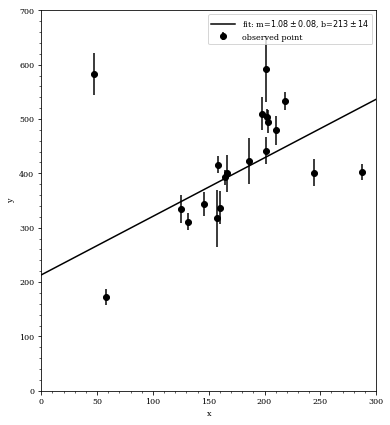

In [40]:
est, dat = linear_algebraic_solution(table1)
m, merr, b, berr = est
X, Y, sY = dat

Xp = np.linspace(0, 300, 100)
plt.figure(figsize=(6,7))
plt.plot(Xp, m*Xp+b, 'k', 
         label='fit: m=$%5.2f\pm{%5.2f}$, b=$%5d\pm{%5d}$'%(m, merr, 
                                                            b, berr) )
plt.errorbar(X, Y, yerr=sY, fmt='ko', label='observed point')
plotting_keys()

# Storing result in a dataframe
caseII_result = {'m':m, 'merr':merr, 'b': b, 'berr':berr, 'case':'Exact solution', 'data': '(x,y,sy) with outliers'}

result_df = result_df.append(pd.Series(caseII_result), ignore_index=True)

Clearly, including outliers ruins the fit. 

#### Case II: Quadratic fit to data with/out outliers

(sub-case without outliers)

In [41]:
def quadratic_algebraic_solution(df):
    Y = df.y.values
    X = df.x.values
    sY = df.sy.values
    A = np.vstack((np.ones(len(X)), X, X*X)).T
    C = np.diag(sY**2)
    invC = np.linalg.inv(C)

    # equation 5 bracket terms
    term_left = np.linalg.inv(np.dot(A.T, np.dot(invC, A)))
    term_right = np.dot(A.T,np.dot(invC, Y))

    b, m, q = np.dot(term_left, term_right)
    berr, merr, qerr = np.sqrt(np.diag(term_left))

    print "m=%1.2f \pm{%1.2f}, b=%2d \pm{%2d}"%(m, merr, b, berr)
    
    return [m, merr, b, berr, q, qerr], [X, Y, sY]

m=1.60 \pm{0.58}, b=72 \pm{38}


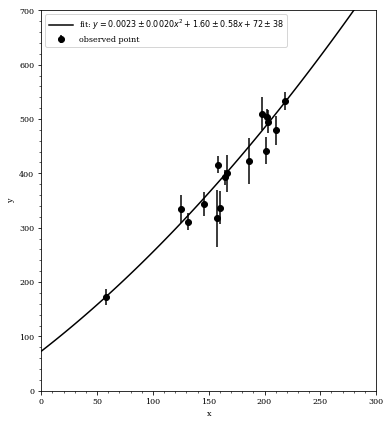

In [42]:
est, dat = quadratic_algebraic_solution(trimmed_table1)
m, merr, b, berr, q, qerr = est
X, Y, sY = dat

Xp = np.linspace(0, 300, 100)
plt.figure(figsize=(6,7))
plt.plot(Xp, q*Xp**2 + m*Xp + b, 'k', 
         label='fit: $y=%5.4f\pm{%5.4f} x^2 + %5.2f\pm{%5.2f} x + %5d\pm{%5d}$'%(q, qerr, 
                                                                            m, merr, 
                                                                            b, berr) )
plt.errorbar(X, Y, yerr=sY, fmt='ko', label='observed point')
plotting_keys()

(sub-case with outliers)

m=3.72 \pm{0.32}, b=18 \pm{27}


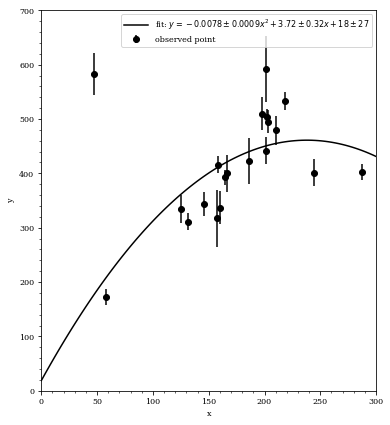

In [43]:
est, dat = quadratic_algebraic_solution(table1)
m, merr, b, berr, q, qerr = est
X, Y, sY = dat

Xp = np.linspace(0, 300, 100)
plt.figure(figsize=(6,7))
plt.plot(Xp, q*Xp**2 + m*Xp + b, 'k', 
         label='fit: $y=%5.4f\pm{%5.4f} x^2 + %5.2f\pm{%5.2f} x + %5d\pm{%5d}$'%(q, qerr, 
                                                                            m, merr, 
                                                                            b, berr) )
plt.errorbar(X, Y, yerr=sY, fmt='ko', label='observed point')
plotting_keys()

## Excercise 2: Bayesian Fit

### Using foreground model only, i.e., only modeling inliers

Case I: Assuming that sy (uncertainties in y) are given

In [44]:
X, Y, sY = trimmed_table1.x, trimmed_table1.y, trimmed_table1.sy
with pm.Model() as basic_model:
    b = pm.Uniform('b', lower=0, upper=100)
    m = pm.Normal('m', mu=0, sd=10)
    
    sigma = sY
        
    fg = pm.Normal('fg', mu=b + m*X, sd=sigma, observed=Y)
    
    step = pm.NUTS()
    trace = pm.sample(5000, n_init=10000, tune=1000)[3000:]

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [m, b_interval__]
100%|██████████| 6000/6000 [00:09<00:00, 655.91it/s]
The acceptance probability does not match the target. It is 0.7158818761719096, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8857044117242815, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.


b: 35.11_{-16.79}^{+18.72}
m: 2.23_{-0.11}^{+0.10}


,case,data,m,merr,b,berr
0,Exact solution,"(x,y,sy) w/o outliers",2.239921,0.107780,34.047728,18.246167
1,Exact solution,"(x,y,sy) with outliers",1.076748,0.077407,213.273492,14.394033
2,Bayesian Fit (BF) only fg model,"(x,y,sy) w/o outliers",2.231750,0.105408,35.109831,17.753674


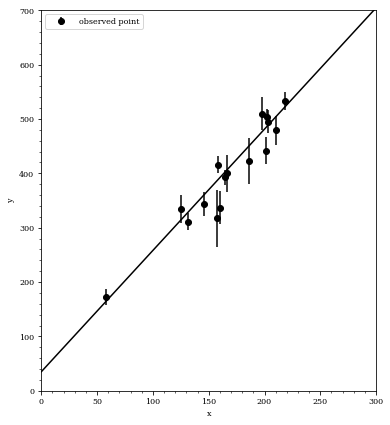

In [45]:
best, bm, bp = xest(trace['b'])
mest, mm, mp = xest(trace['m'])
print "b: %1.2f_{-%1.2f}^{+%1.2f}"%(best, bm, bp)
print "m: %1.2f_{-%1.2f}^{+%1.2f}"%(mest, mm, mp)

Xp = np.linspace(0, 300, 10)
plt.figure(figsize=(6,7))
plt.plot(Xp, mest*Xp + best, 'k')
plt.errorbar(X, Y, yerr=sY, fmt='ko', label='observed point')
plotting_keys()

# Storing result in a dataframe
caseIII_result = {'m':mest, 'merr':0.5*(mm+mp), 'b': best, 'berr':0.5*(bm+bp), 
                  'case':'Bayesian Fit (BF) only fg model', 'data': '(x,y,sy) w/o outliers'}

result_df = result_df.append(pd.Series(caseIII_result), ignore_index=True)

Case II: Assuming that sy are known, but data is generated from t-distribution. Fit in this case is better than Case I immediately above.

In [46]:
X, Y, sY = trimmed_table1.x, trimmed_table1.y, trimmed_table1.sy
with pm.Model() as basic_model:
    b = pm.Uniform('b', lower=0, upper=100)
    m = pm.Normal('m', mu=0, sd=10)
    
    sigma = sY
      
    ## define prior for Student T degrees of freedom
    nu = pm.Uniform('nu', lower=1, upper=100)

    fg = pm.StudentT('fg', mu=b + m*X, sd=sigma, nu=nu, observed=Y)
    
    step = pm.NUTS()
    trace = pm.sample(5000, n_init=10000, tune=1000)[3000:]

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [nu_interval__, m, b_interval__]
100%|██████████| 6000/6000 [00:13<00:00, 444.96it/s]
The acceptance probability does not match the target. It is 0.9015451248380363, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8909939830878917, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8804086795342341, but should be close to 0.8. Try to increase the number of tuning steps.


In [47]:
best, bm, bp = xest(trace['b'])
mest, mm, mp = xest(trace['m'])
print "b: %1.2f_{-%1.2f}^{+%1.2f}"%(best, bm, bp)
print "m: %1.2f_{-%1.2f}^{+%1.2f}"%(mest, mm, mp)

# Storing result in a dataframe
caseIV_result = {'m':mest, 'merr':0.5*(mm+mp), 'b': best, 'berr':0.5*(bm+bp), 
                  'case':'BF only fg (t-distribution)', 'data':'(x,y,sy) w/o outliers'}

result_df = result_df.append(pd.Series(caseIV_result), ignore_index=True)

b: 34.19_{-17.15}^{+17.58}
m: 2.24_{-0.10}^{+0.10}


,case,data,m,merr,b,berr
0,Exact solution,"(x,y,sy) w/o outliers",2.239921,0.107780,34.047728,18.246167
1,Exact solution,"(x,y,sy) with outliers",1.076748,0.077407,213.273492,14.394033
2,Bayesian Fit (BF) only fg model,"(x,y,sy) w/o outliers",2.231750,0.105408,35.109831,17.753674
3,BF only fg (t-distribution),"(x,y,sy) w/o outliers",2.238888,0.102725,34.190233,17.367511


Case III: Assuming that $\sigma_{yii}$ are not known and hence, considering it a free parameter. 

In [48]:
X, Y, sY = trimmed_table1.x, trimmed_table1.y, trimmed_table1.sy
with pm.Model() as basic_model:
    b = pm.Uniform('b', lower=0, upper=100)
    m = pm.Normal('m', mu=0, sd=10)
    
    sigma = pm.Uniform('sigma', lower=0, upper=20)
        
    fg = pm.Normal('fg', mu=b + m*X, sd=sigma, observed=Y)
    
with basic_model:
    step = pm.NUTS()
    trace = pm.sample(5000, n_init=10000, tune=1000)[3000:]

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma_interval__, m, b_interval__]
100%|██████████| 6000/6000 [00:13<00:00, 444.14it/s]
The acceptance probability does not match the target. It is 0.6575641949805455, but should be close to 0.8. Try to increase the number of tuning steps.


b: 30.50_{-17.90}^{+19.43}
m: 2.21_{-0.11}^{+0.11}


,case,data,m,merr,b,berr
0,Exact solution,"(x,y,sy) w/o outliers",2.239921,0.107780,34.047728,18.246167
1,Exact solution,"(x,y,sy) with outliers",1.076748,0.077407,213.273492,14.394033
2,Bayesian Fit (BF) only fg model,"(x,y,sy) w/o outliers",2.231750,0.105408,35.109831,17.753674
3,BF only fg (t-distribution),"(x,y,sy) w/o outliers",2.238888,0.102725,34.190233,17.367511
4,BF only fg (Normal),"(x,y) w/o outliers, sy is free parameter",2.205762,0.108824,30.498864,18.664294


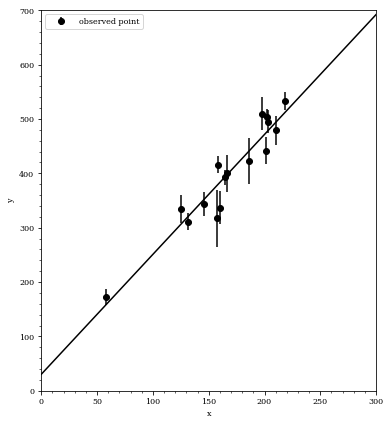

In [49]:
#pm.traceplot(trace);
best, bm, bp = xest(trace['b'])
mest, mm, mp = xest(trace['m'])
print "b: %1.2f_{-%1.2f}^{+%1.2f}"%(best, bm, bp)
print "m: %1.2f_{-%1.2f}^{+%1.2f}"%(mest, mm, mp)

Xp = np.linspace(0, 300, 10)
plt.figure(figsize=(6,7))
plt.plot(Xp, mest*Xp + best, 'k')
plt.errorbar(X, Y, yerr=sY, fmt='ko', label='observed point')
plotting_keys()

# Storing result in a dataframe
caseV_result = {'m':mest, 'merr':0.5*(mm+mp), 'b': best, 'berr':0.5*(bm+bp), 
                  'case':'BF only fg (Normal)','data':'(x,y) w/o outliers, sy is free parameter'}

result_df = result_df.append(pd.Series(caseV_result), ignore_index=True)

Case IV: Assuming that sy are non-existence. Including eps term to model dispersion in the data along the y-direction 

In [50]:
X, Y = trimmed_table1.x, trimmed_table1.y
with pm.Model() as basic_model:
    b = pm.Uniform('b', lower=0, upper=100)
    m = pm.Normal('m', mu=0, sd=10)
    
    sigma = 1. #pm.Uniform('sigma', 1e0-2, 20)
    eps = pm.Normal('eps', mu=0, sd=5)
    
    yest = b + m*X + eps    
    fg = pm.Normal('fg', mu=yest, sd=sigma, observed=Y)
    
    step = pm.NUTS()
    trace = pm.sample(5000, n_init=10000, tune=1000)[3000:]

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [eps, m, b_interval__]
100%|██████████| 6000/6000 [00:49<00:00, 120.99it/s]
The acceptance probability does not match the target. It is 0.8816564954347734, but should be close to 0.8. Try to increase the number of tuning steps.


b: 28.81_{-4.93}^{+5.03}
m: 2.22_{-0.01}^{+0.01}


,case,data,m,merr,b,berr
0,Exact solution,"(x,y,sy) w/o outliers",2.239921,0.107780,34.047728,18.246167
1,Exact solution,"(x,y,sy) with outliers",1.076748,0.077407,213.273492,14.394033
2,Bayesian Fit (BF) only fg model,"(x,y,sy) w/o outliers",2.231750,0.105408,35.109831,17.753674
3,BF only fg (t-distribution),"(x,y,sy) w/o outliers",2.238888,0.102725,34.190233,17.367511
4,BF only fg (Normal),"(x,y) w/o outliers, sy is free parameter",2.205762,0.108824,30.498864,18.664294
5,BF only fg (Normal + eps),"(x,y) w/o outliers, sy is free parameter",2.216612,0.006261,28.812264,4.980548


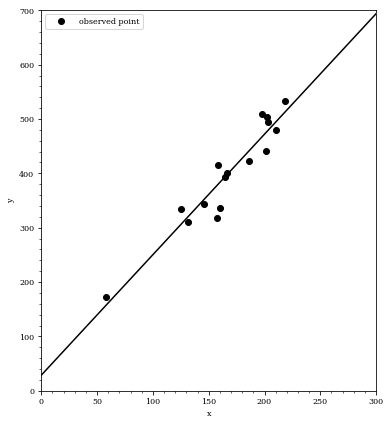

In [51]:
best, bm, bp = xest(trace['b'])
mest, mm, mp = xest(trace['m'])
print "b: %1.2f_{-%1.2f}^{+%1.2f}"%(best, bm, bp)
print "m: %1.2f_{-%1.2f}^{+%1.2f}"%(mest, mm, mp)

Xp = np.linspace(0, 300, 10)
plt.figure(figsize=(6,7))
plt.plot(Xp, mest*Xp + best, 'k')
plt.plot(X, Y, 'ko', label='observed point')
plotting_keys()

# Storing result in a dataframe
caseVI_result = {'m':mest, 'merr':0.5*(mm+mp), 'b': best, 'berr':0.5*(bm+bp), 
                 'case':'BF only fg (Normal + eps)', 'data': '(x,y) w/o outliers, sy is free parameter'}

result_df = result_df.append(pd.Series(caseVI_result), ignore_index=True)

### A robust fitting for data with outliers using a mixture (foreground + background) model

Case I: Assuming that $\sigma_{yii}$ are known

In [53]:
X, Y, sY = table1.x, table1.y, table1.sy
n = X.shape[0]
with pm.Model() as basic_model:
    # Weights
    q = pm.Beta( "q", 1., 1.)    
    #nmixture = 2
    #q = pm.Dirichlet('q', np.ones(nmixture))
    
    # Priors on inliers slope and intercept
    b = pm.Uniform('b', lower=0, upper=100)
    m = pm.Normal('m', mu=0, sd=20)
    
    # y measurement and uncertainties 
    yest = b + m*X
    sigma = sY
    #sigma  = pm.Uniform('sigma', 1e0-2, 20)
    
    # Priors on outliers means and dispersion 
    Yb = pm.Normal('Yb', mu=0, sd=200)
    Vb = pm.Uniform('Vb', 1e-2, 100)
            
    fg = pm.Normal.dist(mu=yest, sd=sigma*np.ones(n), shape=n)
    bg = pm.Normal.dist(mu=Yb*np.ones(n), 
                        sd=np.sqrt(Vb**2 + sigma**2), shape=n)
    
    mix = pm.Mixture('mix', w=[q, 1-q], #q, 
                       comp_dists = [fg, bg], observed=Y)
    
    step = pm.NUTS( )
    trace = pm.sample(5000, n_init=10000, tune=5000)[1000:]

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [Vb_interval__, Yb, m, b_interval__, q_logodds__]
100%|██████████| 10000/10000 [00:37<00:00, 268.19it/s]
The acceptance probability does not match the target. It is 0.7083632574065712, but should be close to 0.8. Try to increase the number of tuning steps.


b: 33.62_{-17.26}^{+18.51}
m: 2.25_{-0.11}^{+0.10}


,case,data,m,merr,b,berr
0,Exact solution,"(x,y,sy) w/o outliers",2.239921,0.107780,34.047728,18.246167
1,Exact solution,"(x,y,sy) with outliers",1.076748,0.077407,213.273492,14.394033
2,Bayesian Fit (BF) only fg model,"(x,y,sy) w/o outliers",2.231750,0.105408,35.109831,17.753674
3,BF only fg (t-distribution),"(x,y,sy) w/o outliers",2.238888,0.102725,34.190233,17.367511
4,BF only fg (Normal),"(x,y) w/o outliers, sy is free parameter",2.205762,0.108824,30.498864,18.664294
5,BF only fg (Normal + eps),"(x,y) w/o outliers, sy is free parameter",2.216612,0.006261,28.812264,4.980548
6,BF with bg+fg,"(x,y,sy) with outliers",2.249742,0.108227,33.623536,17.881737


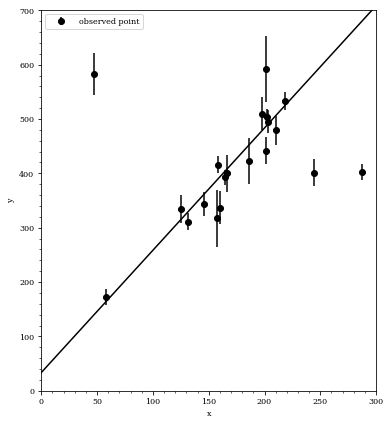

In [54]:
#pm.traceplot(trace);
def xest(x):
    m, est, p = np.percentile(x, [16, 50, 84])
    return est, est-m, p-est

best, bm, bp = xest(trace['b'])
mest, mm, mp = xest(trace['m'])
print "b: %1.2f_{-%1.2f}^{+%1.2f}"%(best, bm, bp)
print "m: %1.2f_{-%1.2f}^{+%1.2f}"%(mest, mm, mp)

Xp = np.linspace(0, 300, 10)
plt.figure(figsize=(6,7))
plt.plot(Xp, mest*Xp + best, 'k')
plt.errorbar(X, Y, yerr=sY, fmt='ko', label='observed point')
plotting_keys()

# Storing result in a dataframe
caseVII_result = {'m':mest, 'merr':0.5*(mm+mp), 'b': best, 'berr':0.5*(bm+bp), 
                  'case':'BF with bg+fg', 'data':'(x,y,sy) with outliers'}

result_df = result_df.append(pd.Series(caseVII_result), ignore_index=True)

Case II: In case sy is not known, hence keeping it a free parameter

In [55]:
X, Y, sY = table1.x, table1.y, table1.sy
n = X.shape[0]
with pm.Model() as basic_model:
    # Weights
    q = pm.Beta( "q", 1., 1.)    
    #nmixture = 2
    #q = pm.Dirichlet('q', np.ones(nmixture))
    
    # Priors on inliers slope and intercept
    b = pm.Uniform('b', lower=0, upper=100)
    m = pm.Normal('m', mu=0, sd=20)
    
    # y measurement and uncertainties 
    yest = b + m*X
    sigma  = pm.Uniform('sigma', 1e0-2, 20)
    
    # Priors on outliers means and dispersion 
    Yb = pm.Normal('Yb', mu=0, sd=200)
    Vb = pm.Uniform('Vb', 1e-2, 100)
            
    fg = pm.Normal.dist(mu=yest, sd=sigma*np.ones(n), shape=n)
    bg = pm.Normal.dist(mu=Yb*np.ones(n), 
                        sd=np.sqrt(Vb**2 + sigma**2), shape=n)
    
    mix = pm.Mixture('mix', w=[q, 1-q], #q, 
                       comp_dists = [fg, bg], observed=Y)
    
    step = pm.NUTS( )
    trace = pm.sample(5000, n_init=10000, tune=5000)[1000:]

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [Vb_interval__, Yb, sigma_interval__, m, b_interval__, q_logodds__]
100%|██████████| 10000/10000 [00:44<00:00, 222.89it/s]


b: 42.81_{-21.20}^{+22.51}
m: 2.17_{-0.17}^{+0.14}
                                 case  \
0                      Exact solution   
1                      Exact solution   
2     Bayesian Fit (BF) only fg model   
3         BF only fg (t-distribution)   
4                 BF only fg (Normal)   
5           BF only fg (Normal + eps)   
6                       BF with bg+fg   
7  BF with bg+fg. (x,y) with outliers   

                                       data         m      merr           b  \
0                     (x,y,sy) w/o outliers  2.239921  0.107780   34.047728   
1                    (x,y,sy) with outliers  1.076748  0.077407  213.273492   
2                     (x,y,sy) w/o outliers  2.231750  0.105408   35.109831   
3                     (x,y,sy) w/o outliers  2.238888  0.102725   34.190233   
4  (x,y) w/o outliers, sy is free parameter  2.205762  0.108824   30.498864   
5  (x,y) w/o outliers, sy is free parameter  2.216612  0.006261   28.812264   
6                    (x,y,

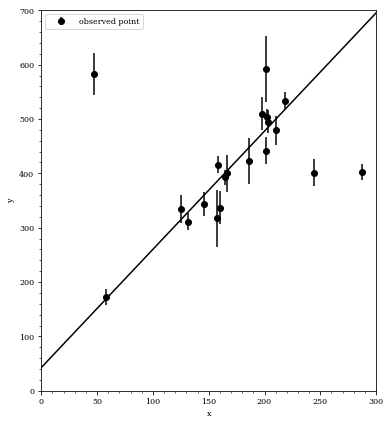

In [56]:
best, bm, bp = xest(trace['b'])
mest, mm, mp = xest(trace['m'])
print "b: %1.2f_{-%1.2f}^{+%1.2f}"%(best, bm, bp)
print "m: %1.2f_{-%1.2f}^{+%1.2f}"%(mest, mm, mp)

Xp = np.linspace(0, 300, 10)
plt.figure(figsize=(6,7))
plt.plot(Xp, mest*Xp + best, 'k')
plt.errorbar(X, Y, yerr=sY, fmt='ko', label='observed point')
plotting_keys()

# Storing result in a dataframe
caseVIII_result = {'m':mest, 'merr':0.5*(mm+mp), 'b': best, 'berr':0.5*(bm+bp), 
                   'case':'BF with bg+fg. (x,y) with outliers', 'data':'sy is a free parameter'}

result_df = result_df.append(pd.Series(caseVIII_result), ignore_index=True)

Case III: In case sy is not known + assuming t-distribution instead of normal distribution

In [57]:
X, Y, sY = table1.x, table1.y, table1.sy
n = X.shape[0]
with pm.Model() as basic_model:
    # Weights
    q = pm.Beta( "q", 1., 1.)    
    #nmixture = 2
    #q = pm.Dirichlet('q', np.ones(nmixture))
    
    # Priors on inliers slope and intercept
    b = pm.Uniform('b', lower=0, upper=100)
    m = pm.Normal('m', mu=0, sd=20)
    
    # y measurement and uncertainties 
    yest = b + m*X
    sigma  = pm.Uniform('sigma', 1e0-2, 20)
    
    # Priors on outliers means and dispersion 
    Yb = pm.Normal('Yb', mu=0, sd=200)
    Vb = pm.Uniform('Vb', 1e-2, 100)

    # Priors for Student-T distribution degrees of freedom
    nu = pm.Uniform('nu', lower=1, upper=100)
    
    fg = pm.StudentT.dist(mu=yest, sd=sigma*np.ones(n), 
                          nu=nu*np.ones(n), shape=n)
    bg = pm.Normal.dist(mu=Yb*np.ones(n), 
                          sd=np.sqrt(Vb**2 + sigma**2), 
                          shape=n)
    
    mix = pm.Mixture('mix', w=[q, 1-q], #q, 
                       comp_dists = [fg, bg], observed=Y)
    
    step = pm.NUTS( )
    trace = pm.sample(5000, n_init=10000, tune=5000)[1000:]

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [nu_interval__, Vb_interval__, Yb, sigma_interval__, m, b_interval__, q_logodds__]
100%|██████████| 10000/10000 [00:56<00:00, 178.32it/s]


b: 42.33_{-21.39}^{+21.83}
m: 2.17_{-0.17}^{+0.14}


,case,data,m,merr,b,berr
0,Exact solution,"(x,y,sy) w/o outliers",2.239921,0.107780,34.047728,18.246167
1,Exact solution,"(x,y,sy) with outliers",1.076748,0.077407,213.273492,14.394033
2,Bayesian Fit (BF) only fg model,"(x,y,sy) w/o outliers",2.231750,0.105408,35.109831,17.753674
3,BF only fg (t-distribution),"(x,y,sy) w/o outliers",2.238888,0.102725,34.190233,17.367511
4,BF only fg (Normal),"(x,y) w/o outliers, sy is free parameter",2.205762,0.108824,30.498864,18.664294
5,BF only fg (Normal + eps),"(x,y) w/o outliers, sy is free parameter",2.216612,0.006261,28.812264,4.980548
6,BF with bg+fg,"(x,y,sy) with outliers",2.249742,0.108227,33.623536,17.881737
7,"BF with bg+fg. (x,y) with outliers",sy is a free parameter,2.174675,0.153343,42.806700,21.855806
8,BF with bg (gaussian) + fg (t-dist),"(x,y) with outliers, sy is free",2.174475,0.152460,42.325035,21.610001


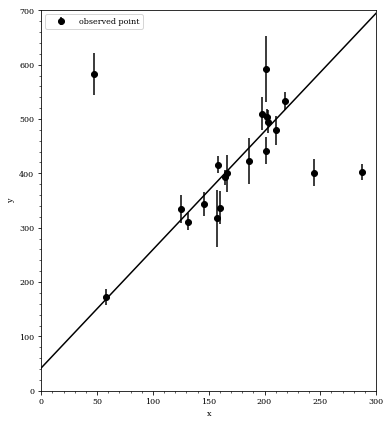

In [58]:
best, bm, bp = xest(trace['b'])
mest, mm, mp = xest(trace['m'])
print "b: %1.2f_{-%1.2f}^{+%1.2f}"%(best, bm, bp)
print "m: %1.2f_{-%1.2f}^{+%1.2f}"%(mest, mm, mp)

Xp = np.linspace(0, 300, 10)
plt.figure(figsize=(6,7))
plt.plot(Xp, mest*Xp + best, 'k')
plt.errorbar(X, Y, yerr=sY, fmt='ko', label='observed point')
plotting_keys()

# Storing result in a dataframe
caseIX_result = {'m':mest, 'merr':0.5*(mm+mp), 'b': best, 'berr':0.5*(bm+bp), 
                  'case':'BF with bg (gaussian) + fg (t-dist)','data':'(x,y) with outliers, sy is free'}

result_df = result_df.append(pd.Series(caseIX_result), ignore_index=True)

### A robust fitting in case there are no uncertainties around the data at all.

In [59]:
X, Y = table1.x, table1.y
n = X.shape[0]
with pm.Model() as basic_model:
    # Weights
    q = pm.Beta( "q", 1., 1.)    
    
    # Priors on inliers slope and intercept
    b = pm.Uniform('b', lower=0, upper=100)
    m = pm.Normal('m', mu=0, sd=20)
        
    # y measurement and uncertainties 
    yest = b + m*X

    sigma  = 1.
    
    # Priors on outliers means and dispersion 
    Yb = pm.Normal('Yb', mu=0, sd=200)
    Vb = pm.Uniform('Vb', 1e-2, 100)
            
    fg = pm.Normal.dist(mu=yest, sd=sigma*np.ones(n), shape=n)
    bg = pm.Normal.dist(mu=Yb*np.ones(n), 
                        sd=np.sqrt(Vb**2 + sigma**2), shape=n)
    
    mix = pm.Mixture('mix', w=[q, 1-q],
                       comp_dists = [fg, bg], observed=Y)
    
    step = pm.Metropolis( )
    trace = pm.sample(5000, n_init=10000, tune=5000)[1000:]

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [Vb_interval__, Yb, m, b_interval__, q_logodds__]
100%|██████████| 10000/10000 [00:39<00:00, 253.53it/s]
There were 416 divergences after tuning. Increase `target_accept` or reparameterize.
There were 16 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 1.9941145089396715e-05, but should be close to 0.8. Try to increase the number of tuning steps.
There were 415 divergences after tuning. Increase `target_accept` or reparameterize.
There were 453 divergences after tuning. Increase `target_accept` or reparameterize.
The gelman-rubin statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


b: 59.49_{-38.18}^{+18.44}
m: 1.88_{-18.08}^{+14.35}


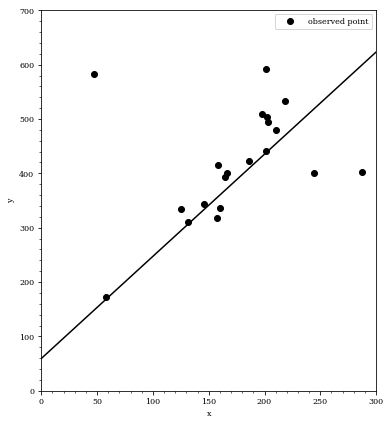

In [62]:
best, bm, bp = xest(trace['b'])
mest, mm, mp = xest(trace['m'])
print "b: %1.2f_{-%1.2f}^{+%1.2f}"%(best, bm, bp)
print "m: %1.2f_{-%1.2f}^{+%1.2f}"%(mest, mm, mp)

Xp = np.linspace(0, 300, 10)
plt.figure(figsize=(6,7))
plt.plot(Xp, mest*Xp + best, 'k')
plt.plot(X, Y, 'ko', label='observed point')
plotting_keys()

# Storing result in a dataframe
caseX_result = {'m':mest, 'merr':0.5*(mm+mp), 'b': best, 'berr':0.5*(bm+bp), 
                  'case':'BF with bg + fg', 'data':'(x,y) with outliers, sigma = 1'}

result_df = result_df.append(pd.Series(caseX_result), ignore_index=True)

#### All estimates

In [61]:
result_df.round(2)[['case', 'data', 'm','merr','b','berr']]

,case,data,m,merr,b,berr
0,Exact solution,"(x,y,sy) w/o outliers",2.24,0.11,34.05,18.25
1,Exact solution,"(x,y,sy) with outliers",1.08,0.08,213.27,14.39
2,Bayesian Fit (BF) only fg model,"(x,y,sy) w/o outliers",2.23,0.11,35.11,17.75
3,BF only fg (t-distribution),"(x,y,sy) w/o outliers",2.24,0.10,34.19,17.37
4,BF only fg (Normal),"(x,y) w/o outliers, sy is free parameter",2.21,0.11,30.50,18.66
5,BF only fg (Normal + eps),"(x,y) w/o outliers, sy is free parameter",2.22,0.01,28.81,4.98
6,BF with bg+fg,"(x,y,sy) with outliers",2.25,0.11,33.62,17.88
7,"BF with bg+fg. (x,y) with outliers",sy is a free parameter,2.17,0.15,42.81,21.86
8,BF with bg (gaussian) + fg (t-dist),"(x,y) with outliers, sy is free",2.17,0.15,42.33,21.61
9,BF with bg + fg,"(x,y) with outliers, sigma = 1",1.88,16.22,59.49,28.31
